In [8]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [30]:
# a)

file_path = '/content/date_promovare_examen.csv'
data = pd.read_csv(file_path)

# Verificam daca datele sunt balansate
promotion_counts = data['Promovare'].value_counts(normalize=True)
print("Proportia fiecarei clase in 'Promovare':")
print(promotion_counts)
print()

X = data[['Ore_Studiu', 'Ore_Somn']].values
y = data['Promovare'].values

# Standardizam
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_standard = (X - X_mean) / X_std

# Construim modelul
with pm.Model() as logistic_model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)

    # Functia logistica
    mu = alpha + pm.math.dot(X_standard, beta)
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))

    # Verosimilatate
    y_obs = pm.Bernoulli('y_obs', p=theta, observed=y)

    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

summary = az.summary(trace, var_names=["alpha", "beta"])
print(summary)

Proportia fiecarei clase in 'Promovare':
Promovare
1    0.5
0    0.5
Name: proportion, dtype: float64



Output()

Output()

ERROR:pymc.stats.convergence:There were 2910 divergences after tuning. Increase `target_accept` or reparameterize.


           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha     0.515  1.631  -2.465    3.623      0.082    0.058     393.0   
beta[0]   5.040  2.404   0.654    9.582      0.140    0.109     297.0   
beta[1]  10.188  3.482   4.080   16.545      0.179    0.126     382.0   

         ess_tail  r_hat  
alpha       581.0   1.00  
beta[0]     247.0   1.00  
beta[1]     822.0   1.01  


Valoarea medie a lui alpha: 0.5154531327408235
Valorile medii ale coef. beta: [ 5.04042677 10.18834894]


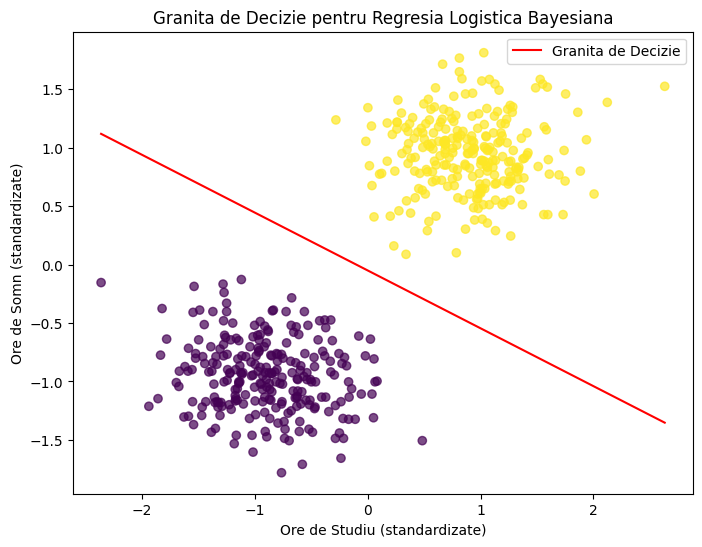

Da, datele sunt liniar separabile.


In [34]:
# b)

alpha_mean = trace.posterior['alpha'].mean().item()
beta_mean = trace.posterior['beta'].mean(axis=(0, 1)).values

print("Valoarea medie a lui alpha:", alpha_mean)
print("Valorile medii ale coef. beta:", beta_mean)

# Granita de decizie: beta[0] * x1 + beta[1] * x2 + alpha = 0
x1 = np.linspace(X_standard[:, 0].min(), X_standard[:, 0].max(), 100)
x2 = -(alpha_mean + beta_mean[0] * x1) / beta_mean[1]

plt.figure(figsize=(8, 6))
plt.scatter(X_standard[:, 0], X_standard[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.plot(x1, x2, color='red', label='Granita de Decizie')
plt.title("Granita de Decizie pentru Regresia Logistica Bayesiana")
plt.xlabel("Ore de Studiu (standardizate)")
plt.ylabel("Ore de Somn (standardizate)")
plt.legend()
plt.show()

print("Da, datele sunt liniar separabile.")

In [33]:
# c)

beta_study = beta_mean[0]
beta_sleep = beta_mean[1]

print("Explicatie influenta variabile:\n")
print(f"Coef. pentru 'Ore de Studiu' este: {beta_study:.4f}")
print(f"Coef. pentru 'Ore de Somn' este: {beta_sleep:.4f}")

if abs(beta_study) > abs(beta_sleep):
    print("\n'Ore de Studiu' influenteaza mai mult probabilitatea de promovare.")
elif abs(beta_sleep) > abs(beta_study):
    print("\n'Ore de Somn' influenteaza mai mult probabilitatea de promovare.")
else:
    print("\nAmbele variabile au aceeasi influenta asupra probabilitatii de promovare.")

Explicatie influenta variabile:

Coef. pentru 'Ore de Studiu' este: 5.0404
Coef. pentru 'Ore de Somn' este: 10.1883

'Ore de Somn' influenteaza mai mult probabilitatea de promovare.
